In [80]:
#import dataset
import pandas as pd
movies_df=pd.read_csv('movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [81]:
rating_df=pd.read_csv('ratings.csv')
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [82]:
#merge the two dataset
merged_dataset=pd.merge(movies_df,rating_df,on='movieId').drop(['genres','timestamp'],axis=1)
merged_dataset.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [83]:
#take the count of votes per movie
rating_count_per_movie=pd.DataFrame(merged_dataset.groupby('title')['rating'].count())
rating_count_per_movie.head()

,rating
title,
'71 (2014),1
'Hellboy': The Seeds of Creation (2004),1
'Round Midnight (1986),2
'Salem's Lot (2004),1
'Til There Was You (1997),2


In [84]:
#describe the rating attribute to see the dispersion
rating_count_per_movie['rating'].describe()

count    9719.000000
mean       10.375141
std        22.406220
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64

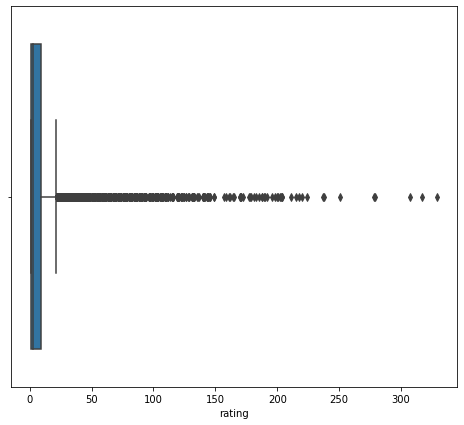

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,7))
sns.boxplot(rating_count_per_movie['rating'])
plt.show()

In [87]:
#Merge the rating_count column with main dataset
merged_dataset_filter=pd.merge(merged_dataset,rating_count_per_movie,on='title')
#take only those movies which have rating count of more than 100 becaue as per the dispersion max movies have atleast 100 count
merged_dataset_filter=merged_dataset_filter[merged_dataset_filter['rating_y'] > 100]
merged_dataset_filter.head()

,movieId,title,userId,rating_x,rating_y
0,1,Toy Story (1995),1,4.0,215
1,1,Toy Story (1995),5,4.0,215
2,1,Toy Story (1995),7,4.5,215
3,1,Toy Story (1995),15,2.5,215
4,1,Toy Story (1995),17,4.5,215


In [88]:
#Remove rating_y from the dataset as it is not required for the training purpose
merged_dataset_filter=merged_dataset_filter.drop('rating_y',axis=1)
merged_dataset_filter=merged_dataset_filter.rename(columns={'rating_x':'rating'})
merged_dataset_filter.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [89]:
#convert the dataset to pivot table
movie_rating_pivot_table=merged_dataset_filter.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_rating_pivot_table.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
Ace Ventura: Pet Detective (1994),0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.5,0.0,3.0
Aladdin (1992),0.0,0.0,0.0,4.0,4.0,5.0,3.0,0.0,0.0,4.0,...,0.0,0.0,0.0,3.0,3.5,0.0,0.0,3.0,0.0,0.0
Alien (1979),4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,4.0,3.0,4.0,0.0,4.5
Aliens (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,3.5,0.0,4.5,0.0,5.0


In [90]:
#training the model
import numpy as np
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'auto')
model_knn.fit(movie_rating_pivot_table)

NearestNeighbors(metric='cosine')

In [98]:
#randomly picking one record for test
import numpy as np
query_index = np.random.choice(movie_rating_pivot_table.shape[0])
#taking the distance and the indices of test set with the 6 nearest neighbors
distances, indices = model_knn.kneighbors(movie_rating_pivot_table.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [99]:
#print the results movies as a recommendation
#flatten will convert the multi d array to 1 d array
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_rating_pivot_table.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_rating_pivot_table.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Kill Bill: Vol. 2 (2004):

1: Kill Bill: Vol. 1 (2003), with distance of 0.14694822463544488:
2: Incredibles, The (2004), with distance of 0.3715879427320994:
3: Pirates of the Caribbean: The Curse of the Black Pearl (2003), with distance of 0.3822603171188046:
4: Batman Begins (2005), with distance of 0.3840320591124696:
5: Fight Club (1999), with distance of 0.38565615909903594:
